# Twitter NFT - Sentiment Analysis and Interaction Graph

### Imports

In [66]:
# Run the pip install command below if you don't already have the library
# !pip install git+https://github.com/JustAnotherArchivist/snscrape.git

# Run the below commands if you don't already have Pandas or TextBlob
#!pip install np
#!pip install textblob

import np
import re

# for scraping / data mining
import snscrape.modules.twitter as sntwitter

# for handling datasets
import pandas as pd

#for sentiment analysis
from textblob import TextBlob

# for graphs
import networkx as nx
import matplotlib.cm as cm
import matplotlib.pyplot as plt

## Twitter Data Mining
### Web scraping with snscrape
First we set some parameters and instantiate a list to append tweets to

In [67]:
# Setting some variables to be used below
maxTweets = 10000
# Change below scrapeQuery to 'ethermon since:2021-06-01 until:2021-06-30' for verifying june month results
scrapeQuery = 'ethermon since:2021-05-01 until:2021-05-30'

# Creating list to append tweet data to
tweets_list = []

Then we use snscrape to get the data according to our query

In [68]:
# Using TwitterSearchScraper to scrape data and append tweets to list
p = 0
for i,tweet in enumerate(sntwitter.TwitterSearchScraper(scrapeQuery).get_items()):
    if i>maxTweets:
        break
    tweets_list.append([tweet.date, tweet.id, tweet.content, tweet.user.username, tweet.user.id, tweet.user, 
                        tweet.inReplyToUser, tweet.mentionedUsers, 
                        tweet.retweetedTweet.user if tweet.retweetedTweet is not None else None, 
                        tweet.quotedTweet.user if tweet.quotedTweet is not None else None,
                        tweet.likeCount, tweet.replyCount, tweet.retweetCount, tweet.quoteCount])

In [69]:
# Creating a dataframe from the tweets list above
tweets_df = pd.DataFrame(tweets_list, columns=['Datetime', 'Tweet_Id', 'Text', 'Username', 'User_Id', 'User', 
                                               'Reply To User', 'Mentioned Users', 'Retweeted User', 'Quoted User',
                                               'Likes', 'Replies', 'Retweets', 'Quotes'])

### Sentiment Analysis
Now we use TextBlob to calculate a sentiment score for each tweet. 

_Note: TextBlob was chosen for now due to its simplicity, but it doesn't seem to do a good job of detecting sentiment expressed using emojis. It may be worthwhile to switch to nltk._

In [70]:
# Calculate the sentiment of each tweet using TextBlob
def sentiment_analysis(tweets):
    tweets["sentiment_score"] = tweets["Text"].apply(lambda x: TextBlob(str(x)).sentiment.polarity)
    tweets["sentiment"] = np.select([tweets["sentiment_score"] < 0,
                                     tweets["sentiment_score"] == 0,
                                     tweets["sentiment_score"] > 0],
                                    ['neg', 'neu', 'pos'])
    return tweets

We also define a function to sum up the sentiment of each user's tweets

In [71]:
# Aggregate the sentiment scores to calculate the overall sentiment per user
def aggregate_sentiment(tweets):
    aggregated = tweets[["Username", "User_Id", "sentiment_score"]].groupby("User_Id").agg(senti_sum=('sentiment_score', 'sum'),
                                                                                           tweet_count=('User_Id', 'count'))
    return aggregated

Now use these functions to get the sentiment analysis data

In [72]:
tweets_df = sentiment_analysis(tweets_df)
agg_df = aggregate_sentiment(tweets_df)

In [73]:
# Display first 20 entries from dataframes

tweets_df.sort_values(by=['sentiment_score'], ascending=False, inplace=True)
tweets_df.head(5)

,Datetime,Tweet_Id,Text,Username,User_Id,User,Reply To User,Mentioned Users,Retweeted User,Quoted User,Likes,Replies,Retweets,Quotes,sentiment_score,sentiment
393,2021-05-18 02:54:57+00:00,1394486636512260101,Vivaaaa! Another ido for my collection!\n#idoc...,MartinSaints,76841292,https://twitter.com/MartinSaints,None,[https://twitter.com/Ethermon_NFT],None,https://twitter.com/Ethermon_NFT,0,0,0,0,1.0,pos
1562,2021-05-05 08:38:24+00:00,1389862029574430720,@Ethermon_NFT @alexsmithTDC @polkastarter SO D...,MartiniGuyYT,782946231551131648,https://twitter.com/MartiniGuyYT,https://twitter.com/Ethermon_NFT,"[https://twitter.com/Ethermon_NFT, https://twi...",None,None,11,0,0,0,1.0,pos
922,2021-05-11 07:18:52+00:00,1392016340244783107,@ICO_Analytics @polylastic @dfinity @RoseonFin...,hurmainzara,1314855715459289088,https://twitter.com/hurmainzara,https://twitter.com/ICO_Analytics,"[https://twitter.com/ICO_Analytics, https://tw...",None,None,2,0,0,0,1.0,pos
1571,2021-05-05 06:45:04+00:00,1389833508005326849,@Ethermon_NFT @polkastarter Awesome!!!! 😊😊😊😊,edwin_jacobsen,1389348418632437764,https://twitter.com/edwin_jacobsen,https://twitter.com/Ethermon_NFT,"[https://twitter.com/Ethermon_NFT, https://twi...",None,None,1,0,0,0,1.0,pos
757,2021-05-12 14:04:37+00:00,1392480839238184962,@Ethermon_NFT @polkastarter look great! $EMON ...,Linh35663509,1107070298422009857,https://twitter.com/Linh35663509,https://twitter.com/Ethermon_NFT,"[https://twitter.com/Ethermon_NFT, https://twi...",None,None,0,0,0,0,1.0,pos


In [75]:
agg_df.sort_values(by=['senti_sum'], ascending=False, inplace=True)
agg_df.head(10)

,senti_sum,tweet_count
User_Id,,
1275458276432285698,16.077536,66
1383178633934565379,3.791071,7
1355825028680454146,3.673437,7
1251163481664966657,2.862716,6
1374232772672294913,2.788312,7
1318069322514714624,2.752814,6
1389348418632437764,2.750000,4
1346445907533787136,2.665714,7
1376495719838720002,2.637500,6


In [76]:
agg_df.sort_values(by=['senti_sum'], inplace=True)
agg_df.head(10)


,senti_sum,tweet_count
User_Id,,
2569187972,-1.000000,1
1339259734214504448,-1.000000,1
1222644860978704386,-0.933333,2
1484196062,-0.923333,2
2459713617,-0.750000,1
905527945598558209,-0.750000,3
1374817651797618688,-0.750000,6
1143441091032702976,-0.750000,1
983008148599525377,-0.750000,2


### Filter the Dataset

In [77]:
# Filter out tweets from users with low tweet count and/or low overall sentiment
def filter_tweets(tweets, aggregated):
    tweets.set_index(['User_Id', 'Tweet_Id'])
    tweets = tweets.join(aggregated, on='User_Id')
    filtered = tweets.drop(tweets[((tweets['tweet_count'] == 1) & (abs(tweets['senti_sum']) < 0.5)) | 
                                  ((tweets['tweet_count'] < 5) & (tweets['senti_sum'] == 0))].index)
    return tweets, filtered

In [78]:
tweets_df, filtered_df = filter_tweets(tweets_df, agg_df)
print(f"Originally had {tweets_df['User_Id'].size} tweets, now {filtered_df['User_Id'].size} after filtering")

Originally had 1721 tweets, now 916 after filtering


## Network Analysis
### Creating a Graph with NetworkX
The nodes are users, and edges interactions between them. Node size represents the number of tweets by the user, and its color the overall sentiment score, with red being positive and blue being negative. Edges are colored according to sentiment as well, and weighted according to the number of likes, replies, retweets and quotes the tweets received. If a user mentions another user in multiple tweets, we group the interactions into one edge.

In [79]:
# Initialize the graph
G = nx.Graph()

In [80]:
# Get a set of tuples representing interactions for each tweet
def get_interactions(tweet):
    user = tweet['User_Id'], tweet['Username']
    
    interacts = set()
    
    interacts.add((tweet['Reply To User'].id if tweet['Reply To User'] else None, tweet['Reply To User'].username if tweet['Reply To User'] else None))
    interacts.add((tweet['Retweeted User'].id if tweet['Retweeted User'] else None, tweet['Retweeted User'].username if tweet['Retweeted User'] else None))
    interacts.add((tweet['Quoted User'].id if tweet['Quoted User'] else None, tweet['Quoted User'].username if tweet['Quoted User'] else None))
    if tweet['Mentioned Users'] is not None:
        for mention in tweet['Mentioned Users']:
            interacts.add((mention.id, mention.username))
        
    interacts.discard(user)
    interacts.discard((None, None))
    
    return user, interacts

In [81]:
for idx, tweet in tweets_df.iterrows():
    u, i = get_interactions(tweet)
    user_id, username = u
    sentiment = tweet['sentiment_score']
    reach = tweet['Likes'] + tweet['Replies'] + tweet['Retweets'] + tweet['Quotes']
    c = cm.coolwarm((1 - sentiment)/2)
    for interaction in i:
        inter_id, inter_user = interaction
        if G.has_edge(user_id, inter_id):
            G.edges[user_id, inter_id]['weight'] += reach
            G.edges[user_id, inter_id]['count'] += 1
            G.edges[user_id, inter_id]['sentiment'] += sentiment
            count = G.edges[user_id, inter_id]['count']
            snew = G.edges[user_id, inter_id]['sentiment']
            cnew = cm.coolwarm((count - snew)/(2*count))
            G.edges[user_id, inter_id]['color'] = cnew
        else:
            G.add_edge(user_id, inter_id, color=c)
            G.edges[user_id, inter_id]['weight'] = reach
            G.edges[user_id, inter_id]['sentiment'] = sentiment
            G.edges[user_id, inter_id]['count'] = 1
        G.nodes[user_id]['sentiment'] = agg_df.at[user_id, 'senti_sum']
        G.nodes[user_id]['count'] = agg_df.at[user_id, 'tweet_count']
        if inter_id in agg_df.index:
            G.nodes[inter_id]['sentiment'] = agg_df.at[inter_id, 'senti_sum']
            G.nodes[inter_id]['count'] = agg_df.at[inter_id, 'tweet_count']
        else:
            G.nodes[inter_id]['sentiment'] = 0
            G.nodes[inter_id]['count'] = 1

### Graph Visualization

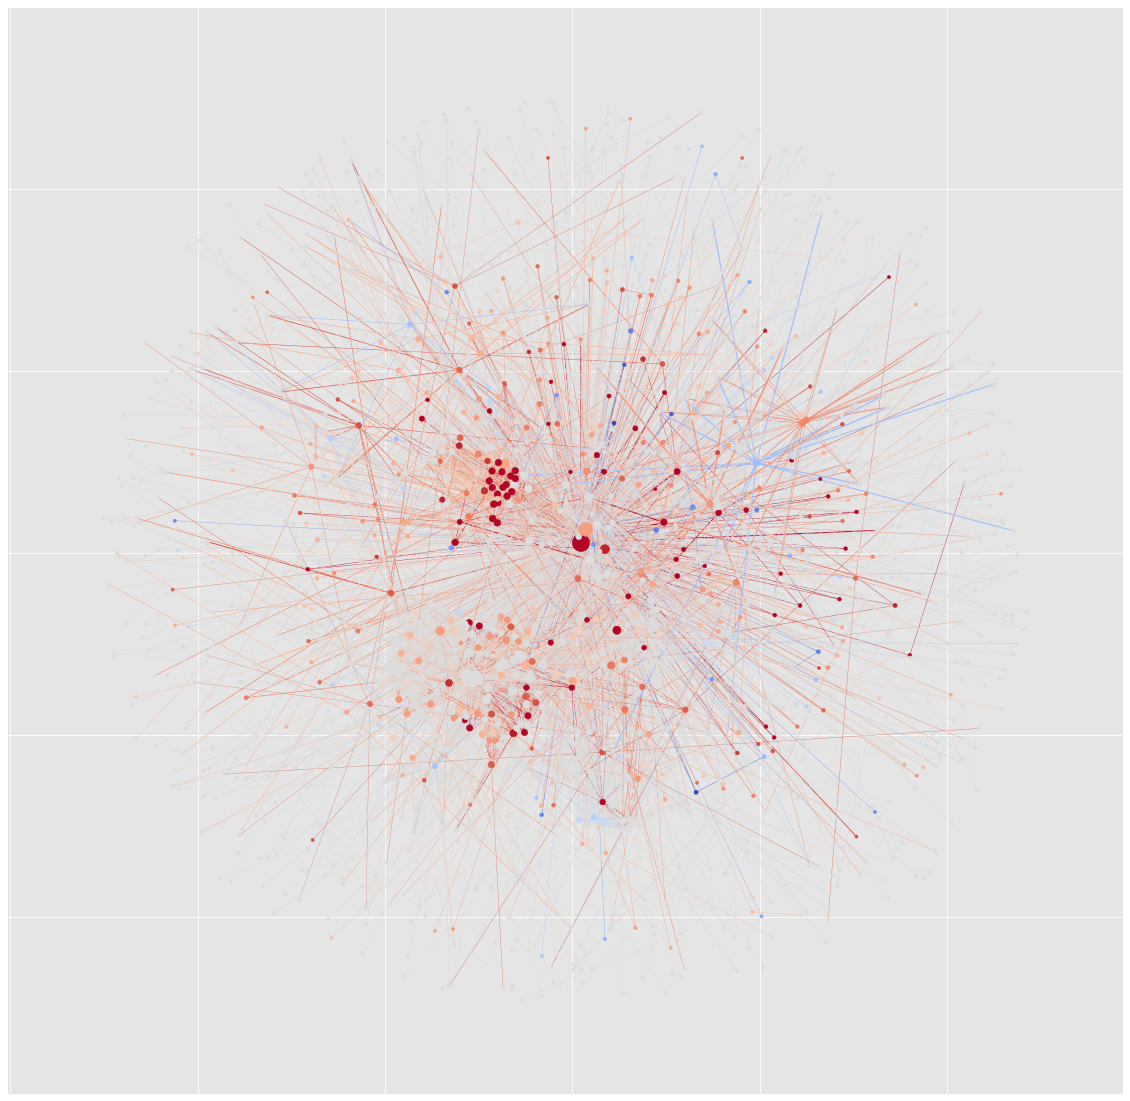

In [89]:
weights = [np.cbrt(w+1) for u, v, w in SG.edges(data="weight")]
lineweights = [5*w/(max(weights)) for w in weights]
edge_sentiments = [s for u, v, s in SG.edges(data='sentiment')]
edge_colors = [(s + 1)/2 if s <= 1 else 1 for s in edge_sentiments]

deg_list = [deg for node, deg in SG.degree()]
node_sizes = [10*np.sqrt(d) for d in deg_list]
node_sentiments = [s if s is not None else 0 for u, s in SG.nodes(data='sentiment')]
node_colors = [(s + 1)/2 if s <= 1 else 1 for s in node_sentiments]

pos = nx.spring_layout(SG, weight='count', k=0.25, scale=.5)

plt.figure(figsize = (20,20))

nx.draw_networkx(SG, pos=pos, node_color=node_colors, cmap=cm.coolwarm, node_size=node_sizes, width=lineweights, 
                 edge_color=edge_colors, edge_cmap=cm.coolwarm, with_labels=False)\

#plt.title("Graph for June’21 phase when the price was completely down from 0.38$ -> 0.05$ drop")
plt.show()

### Graph Measures

#### Degree distribution and histogram for June'21 phase data

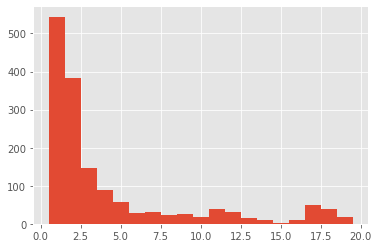

In [83]:
def plot_degree_dist(G):
    degrees = [G.degree(n) for n in G.nodes()]
    plt.style.use('ggplot')
    bins = np.arange(0,20)+0.5
    plt.hist(degrees,bins=bins)
    plt.show()

plot_degree_dist(G)

#### Basic Graph Analysis

In [84]:
print(f"Nodes (users): {G.number_of_nodes()}\nEdges (interactions): {G.number_of_edges()}")

Nodes (users): 1663
Edges (interactions): 6052


In [85]:
# Get some measures of the nodes' degrees
deg_list = [deg for node, deg in G.degree()]
print(f"Max degree: {np.max(deg_list)}\nMean degree: {np.mean(deg_list):.2f}")

Max degree: 919
Mean degree: 7.28


In [86]:
# Find the largest connected component and make a subgraph
top_comp = max(nx.connected_components(G), key=len)
SG = G.subgraph(top_comp)
print(f"Largest connected component:\nNodes: {SG.number_of_nodes()}\nEdges: {SG.number_of_edges()}")

# Find the average connected component size
avg_nodes = np.mean([G.subgraph(comp).number_of_nodes() for comp in nx.connected_components(G)])
avg_edges = np.mean([G.subgraph(comp).number_of_edges() for comp in nx.connected_components(G)])
print(f"Average of connected components:\nNodes: {avg_nodes}\nEdges: {avg_edges}")

Largest connected component:
Nodes: 1636
Edges: 6035
Average of connected components:
Nodes: 151.1818181818182
Edges: 550.1818181818181


#### Degree of Centrality - (Top 6 user nodes with greatest degree of centrality) 

In [87]:
res = {k: v for k, v in sorted(nx.degree_centrality(G).items(), key=lambda item: item[1], reverse=True)}
dict(list(res.items())[0:6])

{1275458276432285698: 0.5529482551143201,
 1294380534496468992: 0.2220216606498195,
 1307651508524126208: 0.08543922984356198,
 1382571790677921793: 0.08363417569193743,
 1339999517714898950: 0.0740072202166065,
 1384042881808166924: 0.07340553549939832}

#### Graph Density

In [88]:
nx.density(G)

0.004379309571309589